# Análisis Descriptivo de la Encuesta de Estructura Salarial

Este cuaderno carga los datos procesados de la EES y replica los análisis descriptivos del fichero `Descriptivos EES.do`.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de los gráficos
sns.set_style("whitegrid")

# Cargar los datos procesados
processed_data_path = os.path.join('..', 'data', 'EES_procesado.parquet')
df = pd.read_parquet(processed_data_path)

print("Datos cargados correctamente.")
print(f"El DataFrame tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
df.head()

Datos cargados correctamente.
El DataFrame tiene 642931 filas y 123 columnas.


,ordenccc,ordentra,region,secc,estrato2,control,mercado,convenio,sexo,tipopais,...,conv__4,conv__5,estudios_1,estudios_2,estudios_3,estudios_4,estudios_6,estudios_7,anoanti2,contrato
0,00000025,01,1,H1,1,1,3,2,0,0,...,0,0,0,0,1,0,0,0,16,4
1,00000025,02,1,H1,1,1,3,2,0,0,...,0,0,0,0,1,0,0,0,100,1
2,00000025,03,1,H1,1,1,3,2,1,0,...,0,0,0,0,0,0,0,1,16,1
3,00000025,04,1,H1,1,1,3,2,0,0,...,0,0,0,0,1,0,0,0,-60,1
4,00000025,05,1,H1,1,1,3,2,0,0,...,0,0,0,0,1,0,0,0,36,1


## Función para Calcular Percentiles Ponderados

Pandas no soporta el cálculo de cuantiles (percentiles) ponderados de forma nativa. Usamos esta función auxiliar para replicar el comportamiento de Stata `[pw=factotal]`.

In [3]:
def weighted_quantile(values, quantiles, sample_weight=None):
    """ Versión ponderada de numpy.quantile.
    NOTE: quantiles debe estar en el rango [0, 1]!
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    # Ordenar valores y pesos
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]

    # Calcular la distribución acumulada ponderada
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

## Cálculo de Percentiles de Salario por Hora

Calculamos los percentiles del logaritmo del salario por hora (`lsalhora`) para hombres (`sexo=0`) y mujeres (`sexo=1`) en cada año, utilizando el factor de ponderación `factotal`.

In [4]:
percentiles = np.arange(0.01, 1.0, 0.01) # Percentiles del 1 al 99
results = {}

for year in [2010, 2014, 2018]:
    for sexo_code, sexo_label in [(0, 'hombres'), (1, 'mujeres')]:
        # Filtrar el dataframe
        subset = df[(df['year'] == year) & (df['sexo'] == sexo_code)].dropna(subset=['lsalhora', 'factotal'])
        
        # Calcular percentiles ponderados
        key = f'{year}_{sexo_label}'
        results[key] = weighted_quantile(
            values=subset['lsalhora'], 
            quantiles=percentiles, 
            sample_weight=subset['factotal']
        )

# Convertir resultados a un DataFrame para facilitar el manejo
pct_df = pd.DataFrame(results)
pct_df['percentil'] = np.arange(1, 100)
pct_df.set_index('percentil', inplace=True)

print("Tabla de percentiles calculados:")
pct_df.head()

Tabla de percentiles calculados:


,2010_hombres,2010_mujeres,2014_hombres,2014_mujeres,2018_hombres,2018_mujeres
percentil,,,,,,
1,1.599972,1.493337,1.489131,1.428066,1.661946,1.588292
2,1.683798,1.577761,1.590196,1.523050,1.741243,1.649422
3,1.753151,1.625055,1.655337,1.576894,1.797453,1.698237
4,1.803777,1.663507,1.706499,1.617312,1.846793,1.731895
5,1.846658,1.696974,1.751896,1.649466,1.890339,1.763365


## Diferencias de Percentiles entre Periodos

Ahora calculamos la diferencia en los percentiles entre los periodos 2010-2014 y 2014-2018.

In [5]:
# Periodo 2010-2014
pct_df['diff_14_10_hombres'] = pct_df['2014_hombres'] - pct_df['2010_hombres']
pct_df['diff_14_10_mujeres'] = pct_df['2014_mujeres'] - pct_df['2010_mujeres']

# Periodo 2014-2018
pct_df['diff_18_14_hombres'] = pct_df['2018_hombres'] - pct_df['2014_hombres']
pct_df['diff_18_14_mujeres'] = pct_df['2018_mujeres'] - pct_df['2014_mujeres']

pct_df.loc[5:95, ['diff_14_10_hombres', 'diff_14_10_mujeres', 'diff_18_14_hombres', 'diff_18_14_mujeres']].head()

,diff_14_10_hombres,diff_14_10_mujeres,diff_18_14_hombres,diff_18_14_mujeres
percentil,,,,
5,-0.094762,-0.047507,0.138443,0.113899
6,-0.089975,-0.041147,0.131426,0.109269
7,-0.084122,-0.040436,0.132202,0.110563
8,-0.075753,-0.036982,0.121596,0.110070
9,-0.069289,-0.037683,0.118899,0.107162


### Gráfico: Crecimiento del Salario por Hora (2010-2014)

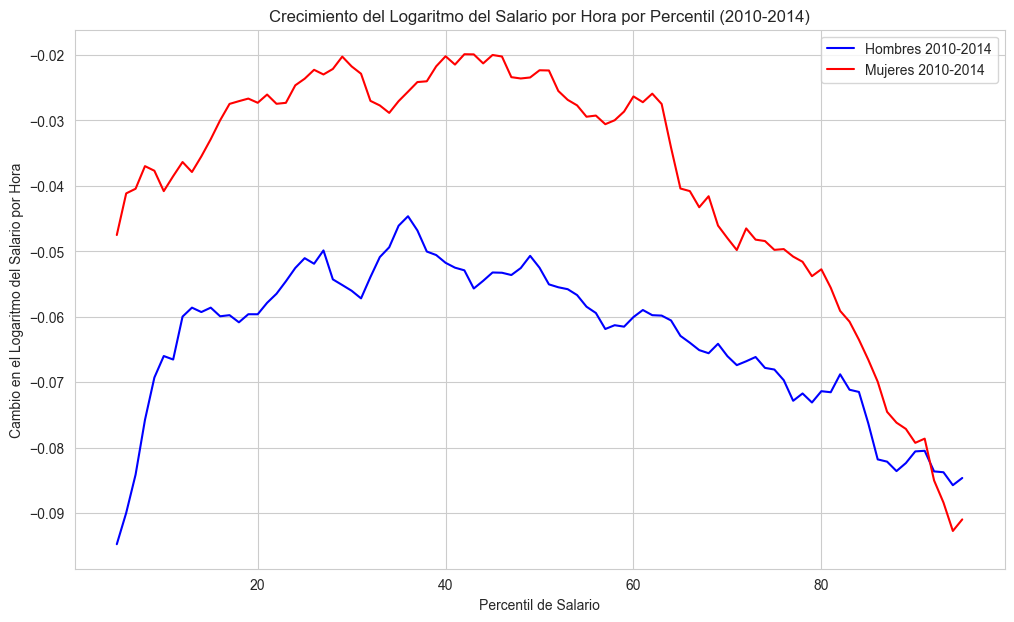

In [6]:
plt.figure(figsize=(12, 7))

# Graficar solo entre el percentil 5 y 95, como en el script de Stata
subset_plot = pct_df.loc[5:95]

plt.plot(subset_plot.index, subset_plot['diff_14_10_hombres'], label='Hombres 2010-2014', color='blue')
plt.plot(subset_plot.index, subset_plot['diff_14_10_mujeres'], label='Mujeres 2010-2014', color='red')

plt.title('Crecimiento del Logaritmo del Salario por Hora por Percentil (2010-2014)')
plt.xlabel('Percentil de Salario')
plt.ylabel('Cambio en el Logaritmo del Salario por Hora')
plt.legend()
plt.grid(True)
plt.show()

### Gráfico: Crecimiento del Salario por Hora (2014-2018)

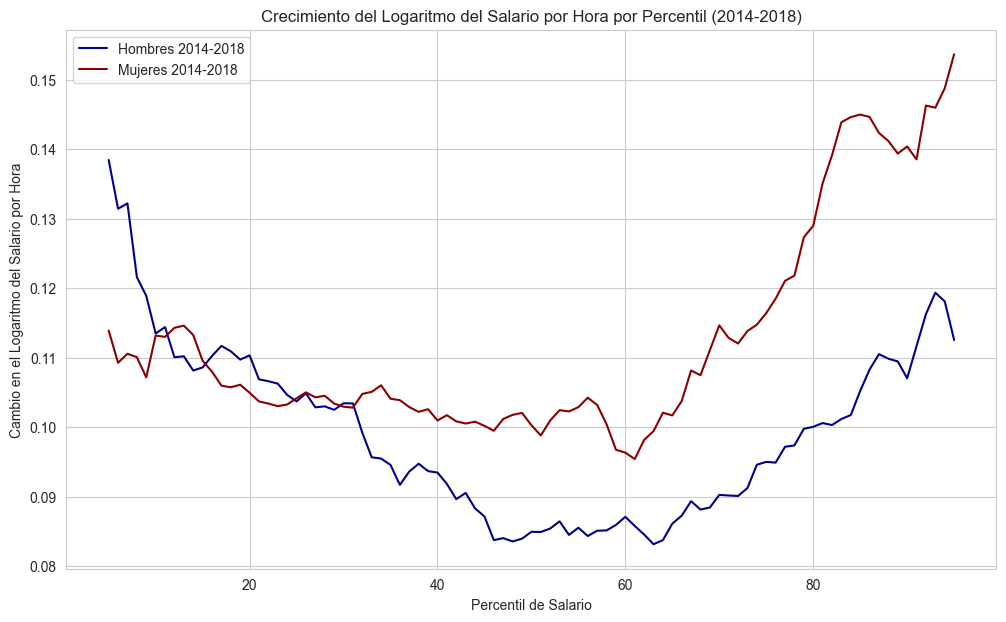

In [7]:
plt.figure(figsize=(12, 7))

# Graficar solo entre el percentil 5 y 95
subset_plot = pct_df.loc[5:95]

plt.plot(subset_plot.index, subset_plot['diff_18_14_hombres'], label='Hombres 2014-2018', color='darkblue')
plt.plot(subset_plot.index, subset_plot['diff_18_14_mujeres'], label='Mujeres 2014-2018', color='darkred')

plt.title('Crecimiento del Logaritmo del Salario por Hora por Percentil (2014-2018)')
plt.xlabel('Percentil de Salario')
plt.ylabel('Cambio en el Logaritmo del Salario por Hora')
plt.legend()
plt.grid(True)
plt.show()